# Machine Learning Project: Argument Detection (evidence-claim)
#### Athens University of Economics and Business
#### MSc in Business Analytics
#### Machine Learning & Content Analytics  
#### Team Members: 
         Mikes Manos  (f2821908)           

         Nikolopoulos Filippos  (f2821909)

         Panagiotatos Konstantinos (f2821911)

## Importing libraries

In [34]:
from __future__ import print_function
import numpy as np
import keras
import tensorflow as tf
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

import re
import os
from glob import glob
from typing import Tuple, List
import pandas as pd
from tqdm import tqdm
from ipywidgets import interact
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import bert
from itertools import cycle
from typing import List, Tuple
import matplotlib.pyplot as plt

from plot_keras_history import plot_history
from scipy import interp

np.random.seed(1228)  # for reproducibility

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

In [35]:
def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

## Import Dataset

In [36]:
#inserting the dataset
class ArgumentParser:

    @staticmethod
    def get_argument_files():
        return list(Path('argument').glob('**/*.csv'))

    def setup_without_context(self):
        files = self.get_argument_files()
        frames = list()

        for file_path in tqdm(files):
          df = pd.read_csv(file_path)
          try:

            df['label'] = df['label'].str.strip()
            df['label'].replace('_', 'NO LABEL', inplace=True)
            df['label'].replace('Missing', 'NO LABEL', inplace=True)
            df['label'] = df['label'].str.strip().str.upper()
            df['document']=str(file_path).split('\\')[-1]

            frames.append(df)
          except:
            print(df.head())
            print(file_path)
            next()

        data = pd.concat(frames).reset_index(drop=True)
        return {'X': data['sentence'].tolist(),
                'y': data['label'].tolist(),
                'df': data}


if __name__ == "__main__":
    parser = ArgumentParser()

    swc_doc = parser.setup_without_context()
    pprint(swc_doc['X'][:5])
    pprint(swc_doc['y'][:5])

100%|██████████| 889/889 [00:03<00:00, 260.65it/s]


['Multivariate Granger causality between CO2 emissions, energy consumption, '
 'FDI (foreign direct investment) and GDP (gross domestic product): Evidence '
 'from a panel of BRIC (Brazil, Russian Federation, India, and China) '
 'countries',
 'Abstract:',
 'This paper addresses the impact of both economic growth and financial '
 'development on environmental degradation using a panel cointegration '
 'technique for the period between 1980 and 2007, except for Russia '
 '(1992–2007).',
 'In long-run equilibrium, CO2 emissions appear to be energy consumption '
 'elastic and FDI inelastic, and the results seem to support the Environmental '
 'Kuznets Curve (EKC) hypothesis.',
 'The causality results indicate that there exists strong bidirectional '
 'causality between emissions and FDI and unidirectional strong causality '
 'running from output to FDI.']
['NO LABEL', 'NO LABEL', 'NO LABEL', 'NO LABEL', 'EVIDENCE']


In [37]:
# Getting a glimpse at some random rows of the dataset
df=swc_doc['df']
df.sample(10)

,label,sentence,document
10081,NO LABEL,n.).,NRT_G7B2_S1055790315001827.csv
171,NO LABEL,"However, there is little data on its health ef...",ABC_G1B1_10.1016_j.envres.2020.109851.csv
6017,NO LABEL,"Background: In 2014, United Nations member sta...",FOP_G3B3_PMID32046109.csv
7161,NO LABEL,The aim of this study is to investigate the ri...,GOQ_G6B2_PMID_30475818.csv
2325,NO LABEL,"Only sex predicted means for all four traits, ...",DEK_G2B2_27.csv
4078,NO LABEL,"A large-scale sample size of more than 46,000 ...",EIK_G4B3_CorpusID_208358160.csv
9175,NO LABEL,Many policies indirectly address climate varia...,LNR_G5B2_10.7892_BORIS.69298.csv
6489,NO LABEL,Title: Evaluation of a school-based health pro...,GHO_G3B4_CorpusID24228496.csv
10862,NO LABEL,Abstract: This exploratory mixed-methods study...,RST_G7B4_S0959378012001288.csv
2553,NO LABEL,Such a pattern is evident in the tracking of g...,DIJ_G2B2_23.csv


In [38]:
df.dtypes

label       object
sentence    object
document    object
dtype: object

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11064 entries, 0 to 11063
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     11064 non-null  object
 1   sentence  11064 non-null  object
 2   document  11064 non-null  object
dtypes: object(3)
memory usage: 259.4+ KB


## Unique labels 

In [40]:
df.label.unique()

array(['NO LABEL', 'EVIDENCE', 'CLAIM'], dtype=object)

## Checking for missing values

In [41]:
# Checking for missing values
df.isna().sum()

label       0
sentence    0
document    0
dtype: int64

## Number of obrservations per label

In [42]:
#getting a sense of the relative numbers of the labels
df.drop(['sentence'],1).groupby(['label']).count()

,document
label,
CLAIM,990
EVIDENCE,1486
NO LABEL,8588


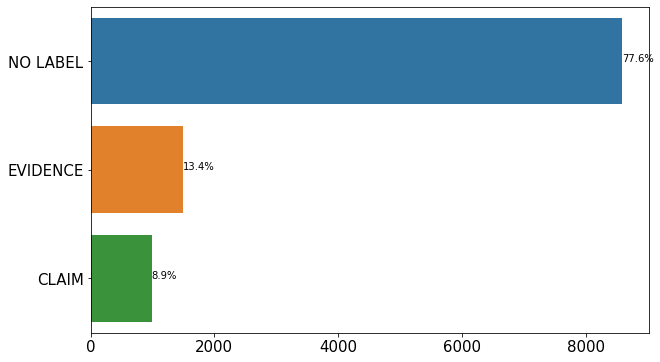

In [43]:
# ploting the cumulative counts of the three labels together with their respective percentages
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(y="label", data=df)
total = len(df)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.05
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
ax.tick_params(labelsize=15)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

## Data preprocessing

In [44]:
# Cleaning the text from unnecessary values and stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['sentence'] = df['sentence'].apply(clean_text)
df.sample(10)

,label,sentence,document
1519,EVIDENCE,cases rotterdam project buyzet logistics hub h...,ABC_G1B3_10.1016_j.trpro.2019.06.045.csv
1947,NO LABEL,abstract,DEJ_G2B1_47.csv
976,NO LABEL,categorizing publications based innovation dri...,ABC_G1B2_10.1016_j.technovation.2018.02.015.csv
10750,NO LABEL,captured individuals field measured body tempe...,RST_G7B4_S0306456514000084.csv
5982,NO LABEL,abstract,FOP_G3B3_PMID30893248.csv
429,NO LABEL,india one order improve economy help make indi...,ABC_G1B1_Corpus ID 190457136.csv
1035,EVIDENCE,2 provinces facing ecological overload excludi...,ABC_G1B3_10.1016_j.ecolind.2019.106035.csv
1651,NO LABEL,women value midwifery continuity care model sy...,DEI_G2B1_6.csv
10039,NO LABEL,promote progress toward climate responsive des...,NRT_G7B1_S0360132312003022.csv
840,NO LABEL,analysis shows clear differences groups low hi...,ABC_G1B2_10.1016_j.renene.2018.08.069.csv


### Splitting the dataset into Train and Test 

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['label'], test_size=0.10, random_state=10, stratify=df['label'])
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(9957,) (9957,)
(1107,) (1107,)


In [46]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

9957 train sequences
1107 test sequences


In [47]:
X_train

840     analysis shows clear differences groups low hi...
888                                              abstract
8758    abstract robust decision making increasingly u...
5149    efq correlations external validators stronger ...
2458    analysis data countries revealed among student...
                              ...                        
3279                                                  aim
5883    results compared men limitation iadl higher pe...
811     also broadened perspective considers ecologica...
2089    conclusion lovi concise coherent validated ind...
4162    household survey key informant interviews focu...
Name: sentence, Length: 9957, dtype: object

In [48]:
y_train

840     NO LABEL
888     NO LABEL
8758    NO LABEL
5149    NO LABEL
2458    NO LABEL
          ...   
3279    NO LABEL
5883    EVIDENCE
811     NO LABEL
2089       CLAIM
4162    NO LABEL
Name: label, Length: 9957, dtype: object

## Classification Models

### Count Vectorizer and Tfidf Transformer

In [49]:
# Bag of words method and SGD Classifier pipeline

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('over', RandomOverSampler(sampling_strategy='minority',random_state=10)),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-4,
                                           random_state=10))
                    ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.7317073170731707

In [50]:
###Classification report

from sklearn import metrics
report = metrics.classification_report(y_test, predicted, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
CLAIM,0.263158,0.505051,0.346021,99.000000
EVIDENCE,0.500000,0.040268,0.074534,149.000000
NO LABEL,0.833149,0.877765,0.854875,859.000000
accuracy,0.731707,0.731707,0.731707,0.731707
macro avg,0.532102,0.474361,0.425143,1107.000000
weighted avg,0.737333,0.731707,0.704336,1107.000000


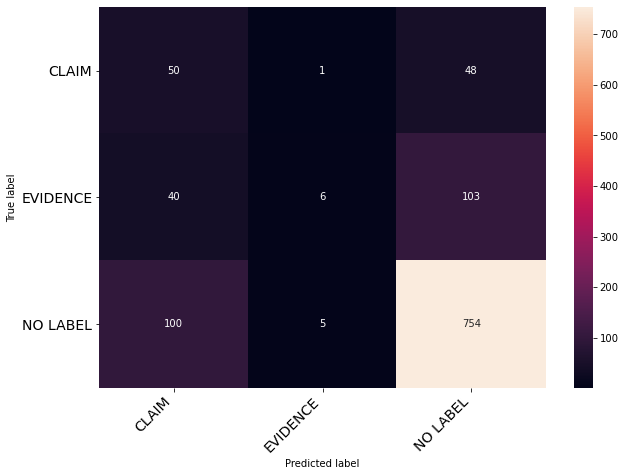

,CLAIM,EVIDENCE,NO LABEL
CLAIM,50,1,48
EVIDENCE,40,6,103
NO LABEL,100,5,754


In [51]:
# Colored confusion matrix
print_confusion_matrix(y_true=y_test,
                           y_pred=predicted,
                           class_names=['CLAIM','EVIDENCE','NO LABEL'])

In [52]:
# Bag of words method and Linear SV Classifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('over', RandomOverSampler(sampling_strategy='minority',random_state=10)),
                     ('clf', LinearSVC())
                    ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.7344173441734417

In [53]:
###Classification report

from sklearn import metrics
report = metrics.classification_report(y_test, predicted, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
CLAIM,0.251701,0.373737,0.300813,99.000000
EVIDENCE,0.423077,0.221477,0.290749,149.000000
NO LABEL,0.842404,0.864959,0.853532,859.000000
accuracy,0.734417,0.734417,0.734417,0.734417
macro avg,0.505727,0.486724,0.481698,1107.000000
weighted avg,0.733136,0.734417,0.728353,1107.000000


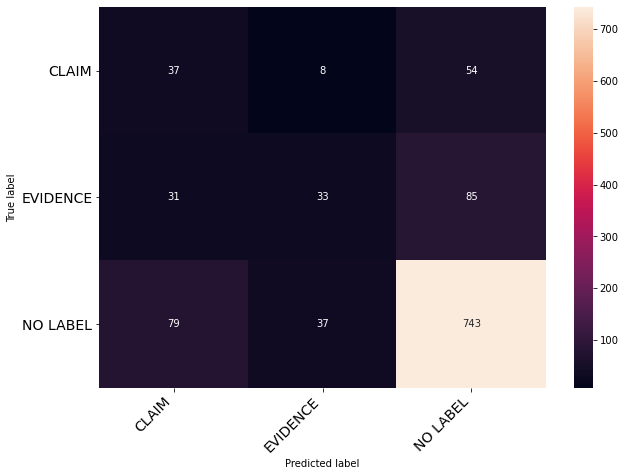

,CLAIM,EVIDENCE,NO LABEL
CLAIM,37,8,54
EVIDENCE,31,33,85
NO LABEL,79,37,743


In [54]:
# Colored confusion matrix
print_confusion_matrix(y_true=y_test,
                           y_pred=predicted,
                           class_names=['CLAIM','EVIDENCE','NO LABEL'])

### Tfidf Vectorizer and Tfidf Transformer

In [55]:
# Tfidf vectorizer and SGD Classifier

text_clf = Pipeline([('vect', TfidfVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('over', RandomOverSampler(sampling_strategy='minority',random_state=10)),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-4,
                                           random_state=10))
                    ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.7398373983739838

In [56]:
###Classification report

from sklearn import metrics
report = metrics.classification_report(y_test, predicted, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
CLAIM,0.269006,0.464646,0.340741,99.000000
EVIDENCE,0.461538,0.040268,0.074074,149.000000
NO LABEL,0.830986,0.892899,0.860831,859.000000
accuracy,0.739837,0.739837,0.739837,0.739837
macro avg,0.520510,0.465938,0.425215,1107.000000
weighted avg,0.731001,0.739837,0.708423,1107.000000


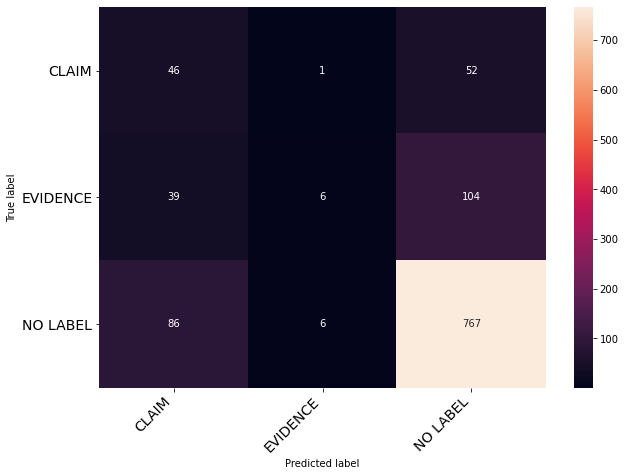

,CLAIM,EVIDENCE,NO LABEL
CLAIM,46,1,52
EVIDENCE,39,6,104
NO LABEL,86,6,767


In [57]:
# Colored confusion matrix
print_confusion_matrix(y_true=y_test,
                           y_pred=predicted,
                           class_names=['CLAIM','EVIDENCE','NO LABEL'])

In [58]:
# Tfidf vectorizer and Linear SV Classifier

text_clf = Pipeline([('vect', TfidfVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('over', RandomOverSampler(sampling_strategy='minority',random_state=10)),
                     ('clf', LinearSVC())
                    ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.7434507678410117

In [59]:
###Classification report

from sklearn import metrics
report = metrics.classification_report(y_test, predicted, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
CLAIM,0.250000,0.323232,0.281938,99.000000
EVIDENCE,0.443038,0.234899,0.307018,149.000000
NO LABEL,0.840000,0.880093,0.859579,859.000000
accuracy,0.743451,0.743451,0.743451,0.743451
macro avg,0.511013,0.479408,0.482845,1107.000000
weighted avg,0.733805,0.743451,0.733547,1107.000000


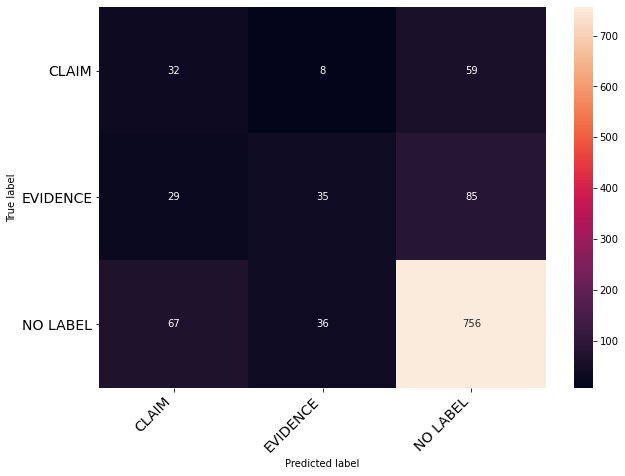

,CLAIM,EVIDENCE,NO LABEL
CLAIM,32,8,59
EVIDENCE,29,35,85
NO LABEL,67,36,756


In [60]:
# Colored confusion matrix
print_confusion_matrix(y_true=y_test,
                           y_pred=predicted,
                           class_names=['CLAIM','EVIDENCE','NO LABEL'])

### Cross Validation with Tfidf vectorizer and transformer 

In [61]:
# Cross validation for Tf-idf method with the train dataset.
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 1), stop_words='english')
sentence0 = tfidf.fit_transform(X_train).toarray()
labels = y_train
sentence0.shape

(9957, 3891)

Maximum accuraccy of model  LinearSVC  is: 0.7864321608040201
Mean accuraccy of model  LinearSVC  is: 0.7646860870769889
Minimum accuraccy of model  LinearSVC  is: 0.7311557788944724
Maximum accuraccy of model  SGDClassifier  is: 0.7969924812030075
Mean accuraccy of model  SGDClassifier  is: 0.7825641994433319
Minimum accuraccy of model  SGDClassifier  is: 0.7688442211055276
Maximum accuraccy of model  DummyClassifier  is: 0.6758793969849246
Mean accuraccy of model  DummyClassifier  is: 0.6249833125527386
Minimum accuraccy of model  DummyClassifier  is: 0.5954773869346733


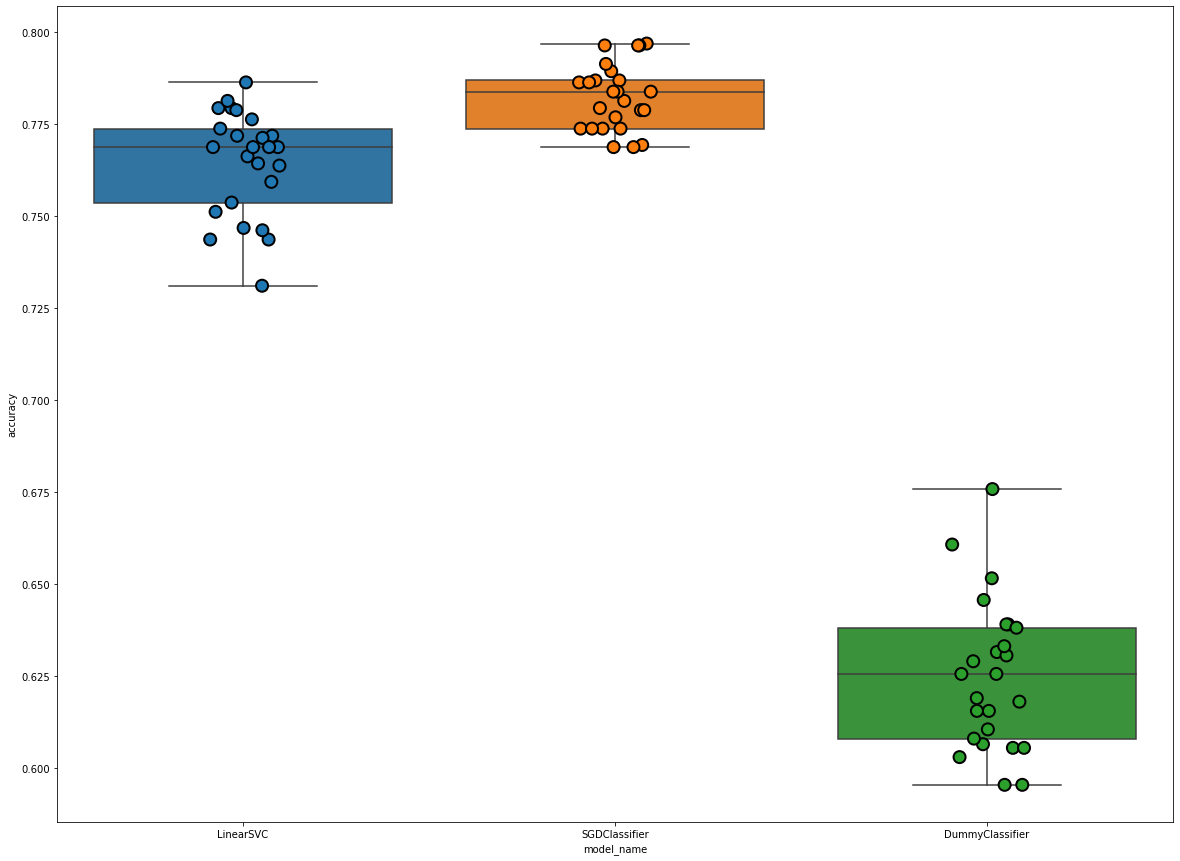

In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
import statistics as st

models = [
    
    LinearSVC(),
    
    SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-04,
                                           random_state=10, n_jobs=-1),
    
    DummyClassifier(strategy="stratified"),
    
]
CV = 25
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries1 = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, sentence0, labels, scoring='accuracy', cv=CV)
  print ("Maximum accuraccy of model ",model_name," is:", max(accuracies))
  print ("Mean accuraccy of model ",model_name," is:", st.mean(accuracies))
  print ("Minimum accuraccy of model ",model_name," is:", min(accuracies))
  for fold_idx, accuracy in enumerate(accuracies):
    entries1.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries1, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
plt.figure(figsize=(20,15))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=12, jitter=True, edgecolor="black", linewidth=2)
plt.show()

In [63]:
# The results of the CV above
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)
dfinal = pd.DataFrame(entries1).transpose()
dfinal=dfinal.T
dfinal.columns=['ModelName','Iteration','Accuracy']
dfinal['Iteration']=dfinal['Iteration']+1
dfinal1=dfinal.groupby(['Iteration','ModelName']).max()
meanDF=dfinal1.groupby(['ModelName']).mean()
meanDF

,Accuracy
ModelName,
DummyClassifier,0.624983
LinearSVC,0.764686
SGDClassifier,0.782564


### Plotting the results of accuracy

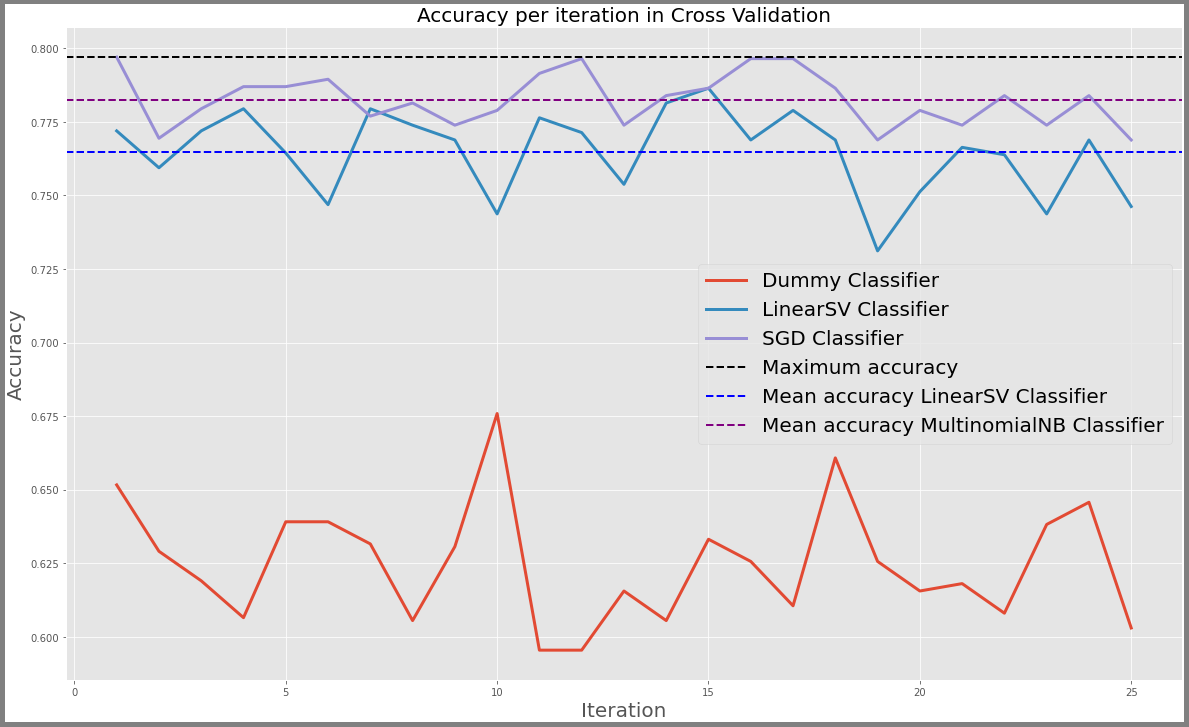

In [64]:
plt.style.use('ggplot')

# plot data
fig, ax = plt.subplots(figsize=(20,12),linewidth=10)
# use unstack()
#data.groupby(['date','type']).count()['amount'].unstack().plot(ax=ax)
dfinal.groupby(['Iteration','ModelName']).sum().unstack().plot(ax=ax,linewidth=3)
plt.axhline(y=max(dfinal.Accuracy),color='black',linestyle='--',linewidth=2)
plt.axhline(y=meanDF.iloc[1].Accuracy,color='blue',linestyle='--',linewidth=2)
plt.axhline(y=meanDF.iloc[2].Accuracy,color='purple',linestyle='--',linewidth=2)
plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title("Accuracy per iteration in Cross Validation",fontsize=20)
plt.legend(["Dummy Classifier", "LinearSV Classifier", "SGD Classifier","Maximum accuracy", "Mean accuracy LinearSV Classifier","Mean accuracy MultinomialNB Classifier","Mean accuracy SGD Classifier"],fontsize=20,loc="best")

### Cross Validation with Count vectorizer and Count transformer 

In [65]:
# Cross validation for bag-of-words method with the train dataset.
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
sentence1 = count_vect.fit_transform(X_train).toarray()
labels1 = y_train
sentence1.shape

(9957, 12234)

C:\Users\konst\anaconda3\envs\EnviromentNew\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\konst\anaconda3\envs\EnviromentNew\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\konst\anaconda3\envs\EnviromentNew\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\konst\anaconda3\envs\EnviromentNew\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\konst\anaconda3\envs\EnviromentNew\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarni

Maximum accuraccy of model  LinearSVC  is: 0.7744360902255639
Mean accuraccy of model  LinearSVC  is: 0.7461072278686667
Minimum accuraccy of model  LinearSVC  is: 0.7110552763819096
Maximum accuraccy of model  SGDClassifier  is: 0.7794486215538847
Mean accuraccy of model  SGDClassifier  is: 0.7529391317489704
Minimum accuraccy of model  SGDClassifier  is: 0.7336683417085427
Maximum accuraccy of model  DummyClassifier  is: 0.6809045226130653
Mean accuraccy of model  DummyClassifier  is: 0.6299104545282805
Minimum accuraccy of model  DummyClassifier  is: 0.5789473684210527


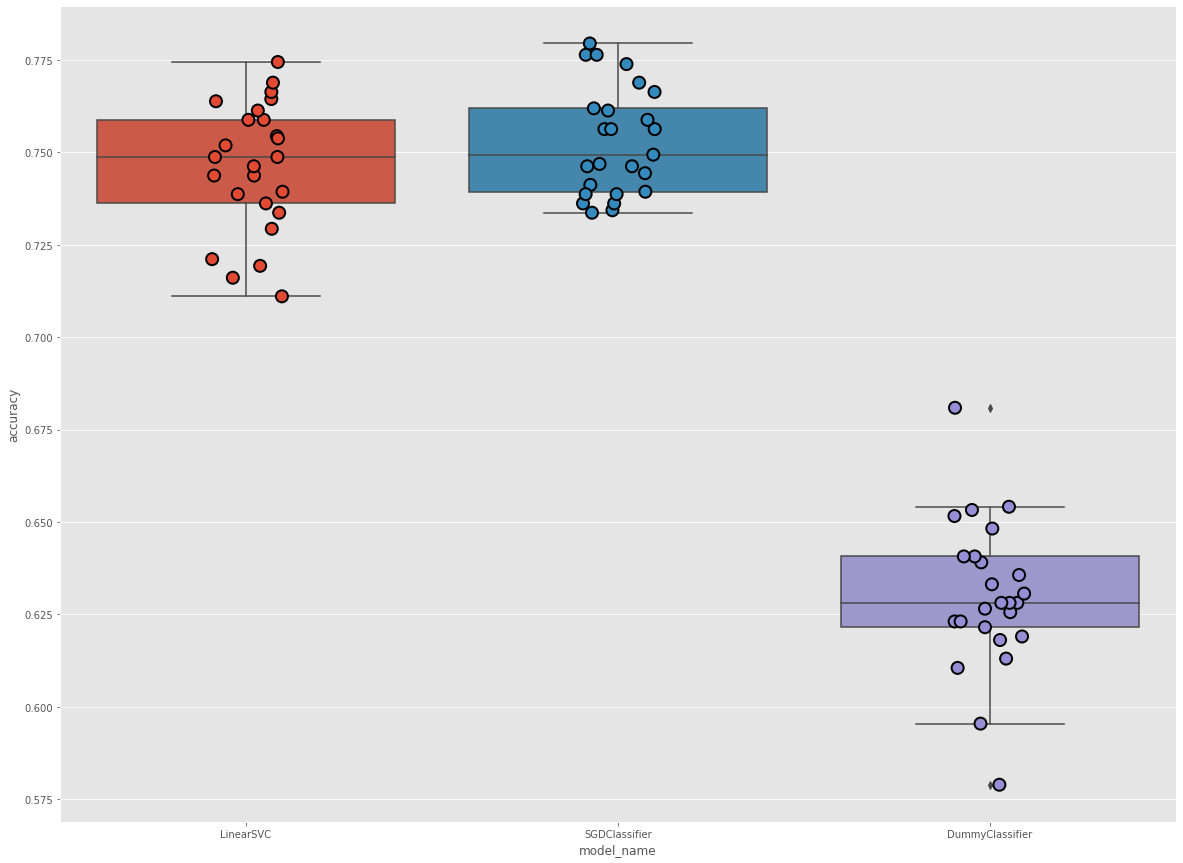

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
import statistics as st

models = [
    
    LinearSVC(),
    
    SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-04,
                                           random_state=10, n_jobs=-1),
    
    DummyClassifier(strategy="stratified"),
    
]
CV = 25
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries2 = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, sentence1, labels1, scoring='accuracy', cv=CV)
  print ("Maximum accuraccy of model ",model_name," is:", max(accuracies))
  print ("Mean accuraccy of model ",model_name," is:", st.mean(accuracies))
  print ("Minimum accuraccy of model ",model_name," is:", min(accuracies))
  for fold_idx, accuracy in enumerate(accuracies):
    entries2.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries2, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
plt.figure(figsize=(20,15))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=12, jitter=True, edgecolor="black", linewidth=2)
plt.show()

In [67]:
# The results of the CV above
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)
dfinal = pd.DataFrame(entries2).transpose()
dfinal=dfinal.T
dfinal.columns=['ModelName','Iteration','Accuracy']
dfinal['Iteration']=dfinal['Iteration']+1
dfinal1=dfinal.groupby(['Iteration','ModelName']).max()
meanDF=dfinal1.groupby(['ModelName']).mean()
meanDF

,Accuracy
ModelName,
DummyClassifier,0.629910
LinearSVC,0.746107
SGDClassifier,0.752939


### Plotting the results of Accuracy

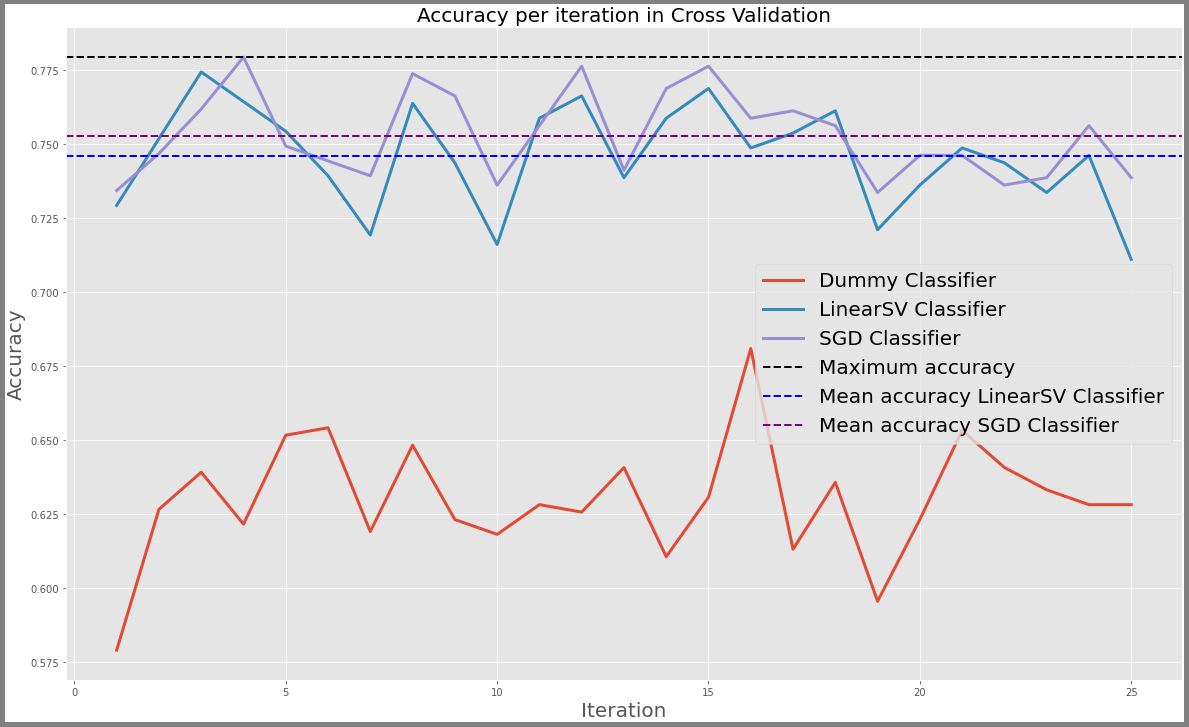

In [68]:
plt.style.use('ggplot')

# plot data
fig, ax = plt.subplots(figsize=(20,12),linewidth=10)
# use unstack()
#data.groupby(['date','type']).count()['amount'].unstack().plot(ax=ax)
dfinal.groupby(['Iteration','ModelName']).sum().unstack().plot(ax=ax,linewidth=3)
plt.axhline(y=max(dfinal.Accuracy),color='black',linestyle='--',linewidth=2)
plt.axhline(y=meanDF.iloc[1].Accuracy,color='blue',linestyle='--',linewidth=2)
plt.axhline(y=meanDF.iloc[2].Accuracy,color='purple',linestyle='--',linewidth=2)
#plt.axhline(y=meanDF.iloc[4].Accuracy,color='orange',linestyle='--',linewidth=2)
plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title("Accuracy per iteration in Cross Validation",fontsize=20)
plt.legend(["Dummy Classifier", "LinearSV Classifier", "SGD Classifier","Maximum accuracy", "Mean accuracy LinearSV Classifier","Mean accuracy SGD Classifier"],fontsize=20,loc="best")

## Checking for the best hyperparameters

#### LinearSV model

In [69]:
text_clf = Pipeline([('vect', TfidfVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('over', RandomOverSampler(sampling_strategy='minority',random_state=10)),
                     ('clf', LinearSVC())
                    ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.7434507678410117

In [70]:
###Classification report

from sklearn import metrics
report = metrics.classification_report(y_test, predicted, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
CLAIM,0.250000,0.323232,0.281938,99.000000
EVIDENCE,0.443038,0.234899,0.307018,149.000000
NO LABEL,0.840000,0.880093,0.859579,859.000000
accuracy,0.743451,0.743451,0.743451,0.743451
macro avg,0.511013,0.479408,0.482845,1107.000000
weighted avg,0.733805,0.743451,0.733547,1107.000000


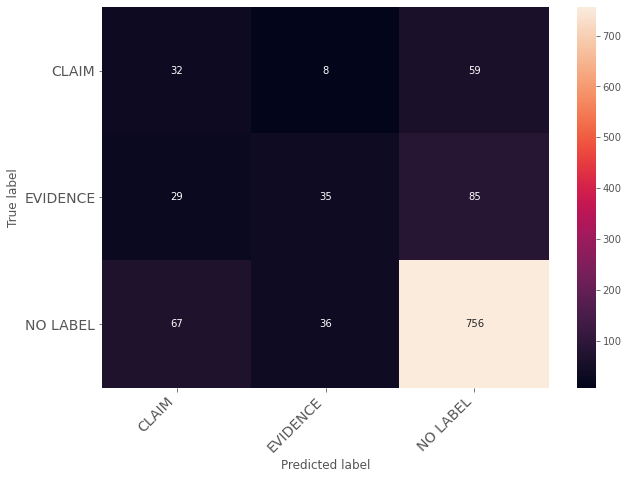

,CLAIM,EVIDENCE,NO LABEL
CLAIM,32,8,59
EVIDENCE,29,35,85
NO LABEL,67,36,756


In [71]:
# Colored confusion matrix
print_confusion_matrix(y_true=y_test,
                           y_pred=predicted,
                           class_names=['CLAIM','EVIDENCE','NO LABEL'])

In [72]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__min_df': [1,3,5],
    'vect__sublinear_tf' : (True, False),
    'vect__strip_accents' : ['ascii', 'None'],
    'vect__stop_words' : ['english','None'],
    'tfidf__use_idf': (True, False),
    'clf__C': [ 1.0,10.0],
    'clf__intercept_scaling': (True, False),
    'clf__penalty': ['l1','l2'],
    }


In [73]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)

In [74]:
gs_clf = gs_clf.fit(X_train, y_train)

In [75]:
gs_clf.best_estimator_

Pipeline(steps=[('vect',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english',
                                 strip_accents='ascii', sublinear_tf=True)),
                ('tfidf', TfidfTransformer()),
                ('over',
                 RandomOverSampler(random_state=10,
                                   sampling_strategy='minority')),
                ('clf', LinearSVC(intercept_scaling=True))])

In [76]:
gs_clf.best_params_

{'clf__C': 1.0,
 'clf__intercept_scaling': True,
 'clf__penalty': 'l2',
 'tfidf__use_idf': True,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english',
 'vect__strip_accents': 'ascii',
 'vect__sublinear_tf': True}

In [77]:
# Running the clasification using the best parameters for SGD and Tfidf.
text_clf = Pipeline([('vect', TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents='ascii',
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                     ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                     ('clf', LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=True,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=10,
                           tol=0.0001, verbose=0))
                    ])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.7750677506775068

In [78]:
###Classification report

from sklearn import metrics
report = metrics.classification_report(y_test, predicted, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
CLAIM,0.458333,0.111111,0.178862,99.000000
EVIDENCE,0.430769,0.187919,0.261682,149.000000
NO LABEL,0.804519,0.953434,0.872669,859.000000
accuracy,0.775068,0.775068,0.775068,0.775068
macro avg,0.564540,0.417488,0.437738,1107.000000
weighted avg,0.723253,0.775068,0.728384,1107.000000


#### SGD model

In [79]:
# Running pipeline again for the best classifier
text_clf = Pipeline([('vect', TfidfVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     #('over', RandomOverSampler(sampling_strategy='minority',random_state=10)),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-4,
                                           random_state=10))
                    ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.7759710930442638

In [80]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__min_df': [1,3,5],
    'vect__strip_accents' : ['ascii', 'None'],
    'vect__stop_words' : ['english','None'],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [1e-5, 1e-4, 1e-3],
    'clf__penalty': ['l1','l2'],
    'clf__max_iter': [ 750,1000,1100],
    
}

In [81]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)

In [82]:
gs_clf = gs_clf.fit(X_train, y_train)

In [83]:
gs_clf.best_estimator_

Pipeline(steps=[('vect',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 2),
                                 stop_words='english', strip_accents='ascii')),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf',
                 SGDClassifier(max_iter=750, penalty='l1', random_state=10))])

In [84]:
gs_clf.best_params_

{'clf__alpha': 0.0001,
 'clf__max_iter': 750,
 'clf__penalty': 'l1',
 'tfidf__use_idf': False,
 'vect__min_df': 3,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english',
 'vect__strip_accents': 'ascii'}

In [85]:
# Running the clasification using the best parameters for SGD and Tfidf.
text_clf = Pipeline([('vect', TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=False,
                                 stop_words='english', strip_accents='ascii',
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None)),
                     ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                     ('clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=750, n_iter_no_change=5, n_jobs=-1,
                               penalty='l1', power_t=0.5, random_state=10,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))
                    ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.7786811201445348

In [86]:
###Classification report

from sklearn import metrics
report = metrics.classification_report(y_test, predicted, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
CLAIM,0.461538,0.060606,0.107143,99.000000
EVIDENCE,0.466667,0.046980,0.085366,149.000000
NO LABEL,0.786840,0.988359,0.876161,859.000000
accuracy,0.778681,0.778681,0.778681,0.778681
macro avg,0.571682,0.365315,0.356223,1107.000000
weighted avg,0.714653,0.778681,0.700948,1107.000000


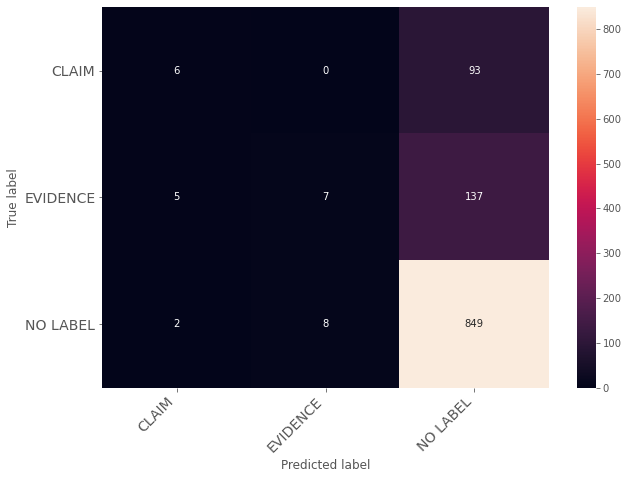

,CLAIM,EVIDENCE,NO LABEL
CLAIM,6,0,93
EVIDENCE,5,7,137
NO LABEL,2,8,849


In [87]:
# Colored confusion matrix
print_confusion_matrix(y_true=y_test,
                           y_pred=predicted,
                           class_names=['CLAIM','EVIDENCE','NO LABEL'])

## New cross validation Tfidf SGD

In [88]:
# Cross validation using the whole dataset
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=False,
                                 stop_words='english', strip_accents='ascii',
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None)

sentenceFin = tfidf.fit_transform(X_train).toarray()
labels = y_train
sentenceFin.shape

(9957, 10430)

Maximum accuraccy of model  LinearSVC  is: 0.7914572864321608
Mean accuraccy of model  LinearSVC  is: 0.7714152214707624
Minimum accuraccy of model  LinearSVC  is: 0.7412060301507538
Maximum accuraccy of model  SGDClassifier  is: 0.7964824120603015
Mean accuraccy of model  SGDClassifier  is: 0.7820642057404819
Minimum accuraccy of model  SGDClassifier  is: 0.7663316582914573
Maximum accuraccy of model  DummyClassifier  is: 0.6608040201005025
Mean accuraccy of model  DummyClassifier  is: 0.6277044369718265
Minimum accuraccy of model  DummyClassifier  is: 0.5939849624060151


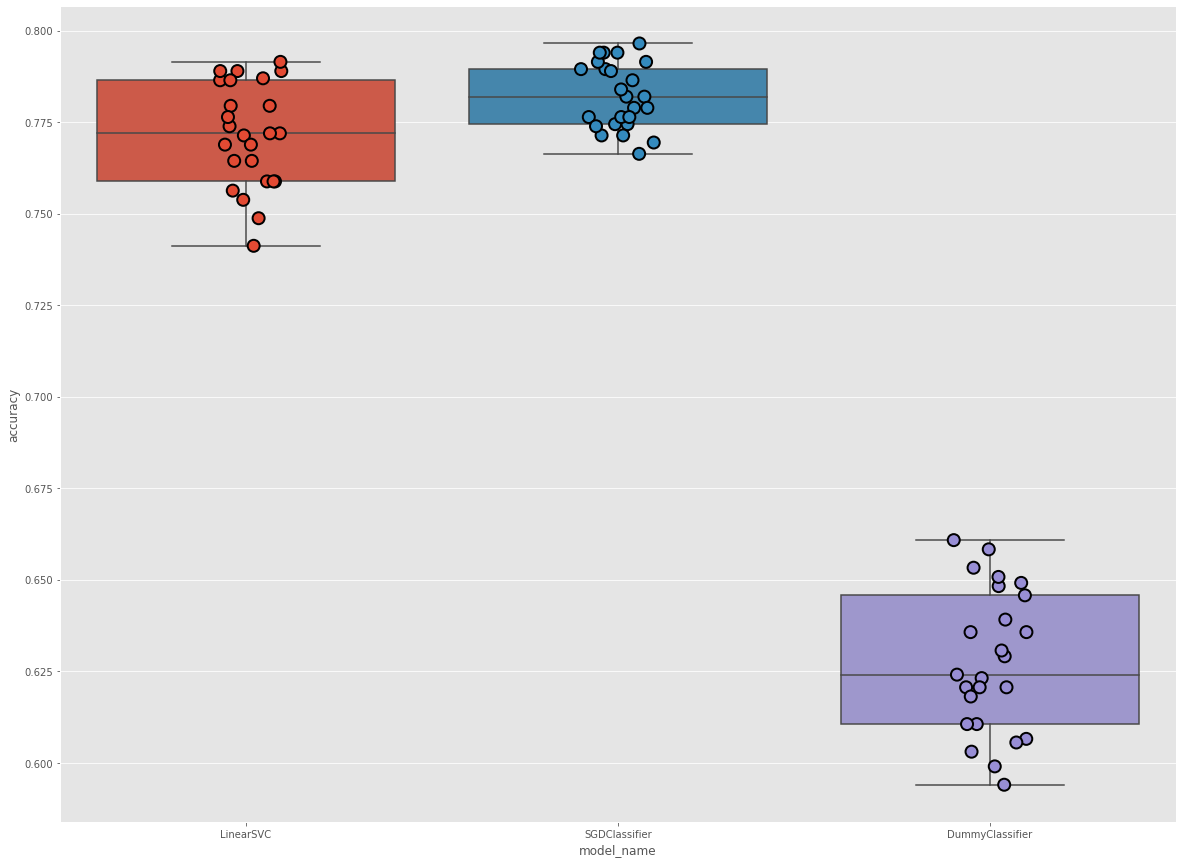

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
import statistics as st

models = [
    LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=True,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=10,
                           tol=0.0001, verbose=0),
    SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=750, n_iter_no_change=5, n_jobs=-1,
                               penalty='l1', power_t=0.5, random_state=10,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False),
    DummyClassifier(strategy="stratified"),
    
]
CV = 25
cv_df = pd.DataFrame(index=range(CV * len(models)))
entriesfin = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, sentenceFin, labels, scoring='accuracy', cv=CV)
  print ("Maximum accuraccy of model ",model_name," is:", max(accuracies))
  print ("Mean accuraccy of model ",model_name," is:", st.mean(accuracies))
  print ("Minimum accuraccy of model ",model_name," is:", min(accuracies))
  for fold_idx, accuracy in enumerate(accuracies):
    entriesfin.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entriesfin, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
plt.figure(figsize=(20,15))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=12, jitter=True, edgecolor="black", linewidth=2)
plt.show()

In [90]:
# The results of the CV above
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)
dfinal = pd.DataFrame(entriesfin).transpose()
dfinal=dfinal.T
dfinal.columns=['ModelName','Iteration','Accuracy']
dfinal['Iteration']=dfinal['Iteration']+1
dfinal1=dfinal.groupby(['Iteration','ModelName']).max()
meanDF=dfinal1.groupby(['ModelName']).mean()

### Plotting the reults of Accuracy

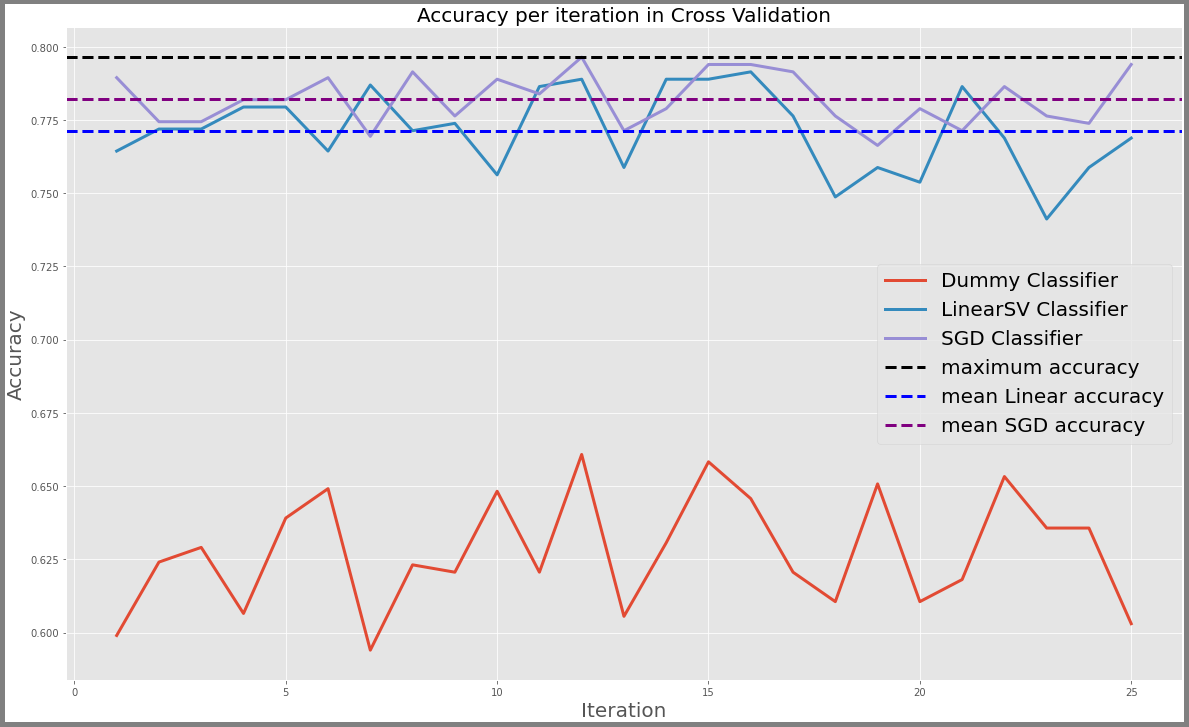

In [91]:
plt.style.use('ggplot')

# plot data
fig, ax = plt.subplots(figsize=(20,12),linewidth=10)
# use unstack()
#data.groupby(['date','type']).count()['amount'].unstack().plot(ax=ax)
dfinal.groupby(['Iteration','ModelName']).sum().unstack().plot(ax=ax,linewidth=3)
plt.axhline(y=max(dfinal.Accuracy),color='black',linestyle='--',linewidth=3)
plt.axhline(y=meanDF.iloc[1].Accuracy,color='blue',linestyle='--',linewidth=3)
plt.axhline(y=meanDF.iloc[2].Accuracy,color='purple',linestyle='--',linewidth=3)
plt.xlabel('Iteration',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title("Accuracy per iteration in Cross Validation",fontsize=20)
plt.legend(["Dummy Classifier", "LinearSV Classifier", "SGD Classifier","maximum accuracy","mean Linear accuracy","mean SGD accuracy"],fontsize=20,loc="best")